# Creating Helper Functions

In [1]:
import sqlite3 as sq
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def run_query(q):
    with sq.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sq.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = 'SELECT\
                name,\
                type\
         FROM sqlite_master\
         WHERE type IN("table","view");'
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Analysing Sales per Genre in the US

In [3]:
q_genre_purchased = "\
 WITH\
     all_purchases AS        \
         (                   \
         SELECT              \
            invoice_id,      \
            billing_country  \
         FROM invoice        \
        ),                   \
                             \
      il_all_purchases AS    \
        (                    \
        SELECT               \
            *                \
        FROM invoice_line il \
        INNER JOIN all_purchases ap ON ap.invoice_id = il.invoice_id\
        ),                   \
                             \
      track_il_purchases AS  \
          (                  \
           SELECT            \
               ilp.*,        \
               t.genre_id    \
           FROM track t      \
           INNER JOIN il_all_purchases ilp ON ilp.track_id = t.track_id\
          ),                 \
                             \
       genre_il_purchases AS \
           (                 \
            SELECT           \
                g.name genre, \
                t.billing_country country\
            FROM track_il_purchases t     \
            INNER JOIN genre g ON g.genre_id = t.genre_id\
           )                 \
                             \
    SELECT\
        genre,               \
        country,             \
        COUNT(*) total_purchase\
    FROM genre_il_purchases  \
    WHERE country = 'USA'    \
    GROUP BY 1, 2            \
    ORDER BY 3 DESC          "
genre_sales_usa= run_query(q_genre_purchased)
genre_sales_usa

,genre,country,total_purchase
0,Rock,USA,561
1,Alternative & Punk,USA,130
2,Metal,USA,124
3,R&B/Soul,USA,53
4,Blues,USA,36
5,Alternative,USA,35
6,Latin,USA,22
7,Pop,USA,22
8,Hip Hop/Rap,USA,20
9,Jazz,USA,14


In [4]:
genre_sales_usa.set_index('genre', inplace= True, drop=True)

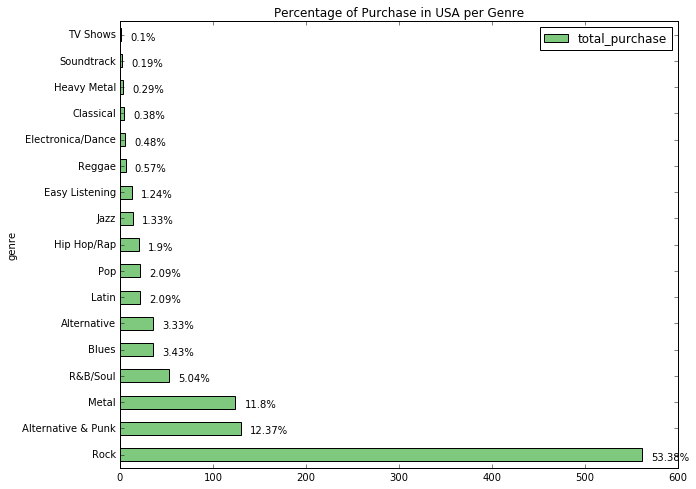

In [5]:
def c_per(sale):
    g_sum = genre_sales_usa['total_purchase'].sum()
    per_n = (sale/g_sum) *100
    per = round(per_n, 2)
    return per

genre_sales_usa['per'] = genre_sales_usa['total_purchase'].apply(c_per)



genre_sales_usa.plot(
    kind='barh', 
    title = "Percentage of Purchase in USA per Genre", 
    figsize=(10,8), 
    y='total_purchase',
    colormap=plt.cm.Accent
                    )

for i, label in enumerate(list(genre_sales_usa.index)):
    g_sold = genre_sales_usa.loc[label, 'total_purchase']
    g_per = str(genre_sales_usa.loc[label,'per']) + "%"
    plt.annotate(g_per, (g_sold + 10, i-0.2))

From our given list:

    1- Hip-Hop
    
    2- Punk
    
    3- Pop
    
    4- Blues

and from our analysis of sales in the US, the above genre rank as follows:

    1- Punk    with  12.3%
    
    2- Blues   with   3.43%
    
    3- Pop     with   2.09%
    
    4- Hip-Hop with   1.9%
    
The data shows that the store should buy the albums from the following artists on a considerable weight of their sales:

    1- Red Tone
    
    2- Slim Jim Bites
    
    3- Meteor and the Girls

In [6]:
q_col_t =" PRAGMA table_info(employee) "
col_t = run_query(q_col_t)
col_t

,cid,name,type,notnull,dflt_value,pk
0,0,employee_id,INTEGER,1,None,1
1,1,last_name,NVARCHAR(20),1,None,0
2,2,first_name,NVARCHAR(20),1,None,0
3,3,title,NVARCHAR(30),0,None,0
4,4,reports_to,INTEGER,0,None,0
5,5,birthdate,DATETIME,0,None,0
6,6,hire_date,DATETIME,0,None,0
7,7,address,NVARCHAR(70),0,None,0
8,8,city,NVARCHAR(40),0,None,0
9,9,state,NVARCHAR(40),0,None,0


# Analysing employee performance with sales total per each

In [7]:
q_emp ="             \
        SELECT\
            *\
        FROM employee\
        LIMIT 2"
emp_df = run_query(q_emp)
emp_df

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


In [8]:
q_emp ="                                                                \
        WITH                                                            \
            supervisor AS                                               \
                (                                                       \
                 SELECT                                                 \
                     employee_id,                                       \
                     first_name || ' ' || last_name supervisor_name,    \
                     title s_title,                                     \
                     reports_to,                                        \
                     birthdate s_birthdate,                             \
                     hire_date s_hiredate,                              \
                     address s_address,                                 \
                     postal_code s_postalcode                           \
                  FROM employee                                         \
                ),                                                      \
                                                                        \
             c_tot_pur AS                                               \
                 (                                                      \
                  SELECT                                                \
                    c.support_rep_id,                                   \
                    c.customer_id,                                      \
                    SUM(i.total) customer_tot_purchase                  \
                  FROM customer c                                       \
                  INNER JOIN invoice i ON i.customer_id = c.customer_id \
                  GROUP BY 2                                            \
                 ),                                                     \
                                                                        \
             e_c AS                                                     \
                 (                                                      \
                  SELECT                                                \
                      *                                                 \
                  FROM employee e                                       \
                  LEFT JOIN c_tot_pur c                                 \
                  ON c.support_rep_id = e.employee_id                   \
                 )                                                      \
                                                                        \
        SELECT                                                          \
          first_name || ' ' || last_name employee_name,                 \
          title,                                                        \
          SUM(customer_tot_purchase) Total_purchase_per_employee,       \
          hire_date                                                     \
        FROM e_c                                                        \
        GROUP BY employee_id                                            \
                 "
emp_df = run_query(q_emp)
emp_df

,employee_name,title,Total_purchase_per_employee,hire_date
0,Andrew Adams,General Manager,NaN,2016-08-14 00:00:00
1,Nancy Edwards,Sales Manager,NaN,2016-05-01 00:00:00
2,Jane Peacock,Sales Support Agent,1731.51,2017-04-01 00:00:00
3,Margaret Park,Sales Support Agent,1584.00,2017-05-03 00:00:00
4,Steve Johnson,Sales Support Agent,1393.92,2017-10-17 00:00:00
5,Michael Mitchell,IT Manager,NaN,2016-10-17 00:00:00
6,Robert King,IT Staff,NaN,2017-01-02 00:00:00
7,Laura Callahan,IT Staff,NaN,2017-03-04 00:00:00


Only the Sales Support Agents are the ones that have customers.

Other employees do not have direct sales.

In [9]:
emp_df = emp_df.dropna()
emp_df

,employee_name,title,Total_purchase_per_employee,hire_date
2,Jane Peacock,Sales Support Agent,1731.51,2017-04-01 00:00:00
3,Margaret Park,Sales Support Agent,1584.00,2017-05-03 00:00:00
4,Steve Johnson,Sales Support Agent,1393.92,2017-10-17 00:00:00


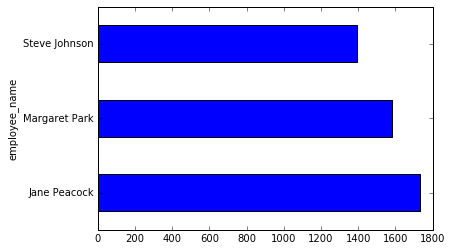

In [10]:
emp_df.plot(kind='barh',
            x= 'employee_name',
            y='Total_purchase_per_employee',
            #x_label='Total sales per employee in dollars',
            legend= False)

Jane seems to be the top sales person. But this can be correlated to her hire date.

The employees are hired in the following order:

Jane --> Margret --> Steve

Therefore, the difference in sales is as far as the analysis go is a function of time

## Analysing if companies make a difference in the sales per employee

In [11]:
q_c = "                                                                  \
       WITH                                                              \
        tot_per_cust AS                                                  \
           (                                                             \
           SELECT                                                        \
                c.support_rep_id,                                        \
                c.company,                                               \
                SUM(total) purchase_total                                \
           FROM customer c                                               \
           INNER JOIN invoice i ON i.customer_id = c.customer_id         \
           GROUP BY i.invoice_id                                         \
           )                                                             \
        SELECT                                                           \
            e.first_name || ' ' || e.last_name employee_name,            \
            tc.company,                                                  \
            SUM(purchase_total) Purchase_per_customer                    \
        FROM employee e                                                  \
        INNER JOIN tot_per_cust tc ON tc.support_rep_id = e.employee_id  \
        GROUP BY 1, 2\
        "
c_tot = run_query(q_c)
c_tot


,employee_name,company,Purchase_per_customer
0,Jane Peacock,None,1419.66
1,Jane Peacock,Apple Inc.,54.45
2,Jane Peacock,Embraer - Empresa Brasileira de Aeronáutica S.A.,108.90
3,Jane Peacock,Riotur,82.17
4,Jane Peacock,Rogers Canada,66.33
5,Margaret Park,None,1304.82
6,Margaret Park,Google Inc.,74.25
7,Margaret Park,JetBrains s.r.o.,144.54
8,Margaret Park,Woodstock Discos,60.39
9,Steve Johnson,None,1196.91


In [12]:
c_tot.set_index('company', inplace= True, drop= True)
c_tot

,employee_name,Purchase_per_customer
company,,
NaN,Jane Peacock,1419.66
Apple Inc.,Jane Peacock,54.45
Embraer - Empresa Brasileira de Aeronáutica S.A.,Jane Peacock,108.90
Riotur,Jane Peacock,82.17
Rogers Canada,Jane Peacock,66.33
NaN,Margaret Park,1304.82
Google Inc.,Margaret Park,74.25
JetBrains s.r.o.,Margaret Park,144.54
Woodstock Discos,Margaret Park,60.39


In [13]:
for each in c_tot.index:
    if each is None:
        c_tot['company'] = 'Misc.'

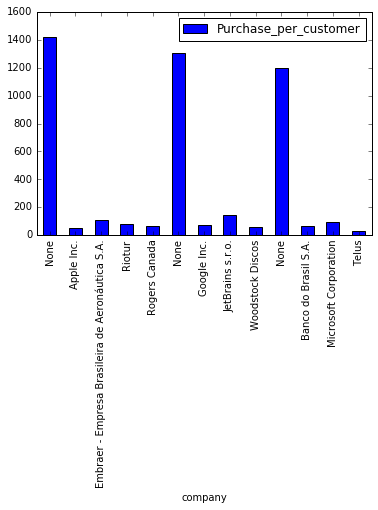

In [14]:
c_tot.plot(kind= 'bar')

It seams that whether a company is a customer or not, does not have an impact on sales of any rep.

# Analysing sales per country

In [15]:
c ='''
    CREATE VIEW c1_country AS
        SELECT
            country,
            COUNT(*) count
        FROM customer
        GROUP BY 1
'''

run_command(c)

OperationalError: table c1_country already exists

In [16]:
qc ='''
        WITH
        
            other_country AS
            (
             SELECT
                 CASE
                     WHEN
                     (
                         SELECT count(*)
                         FROM customer
                         WHERE country = c.country
                     )= 1 THEN "Other"
                     ELSE c.country
                     END AS country,
                 COUNT(c.customer_id) no_of_customers,
                 SUM(i.total) total_in_dollars,
                 (SUM(i.total)/COUNT(DISTINCT c.customer_id)) avg_per_cust,
                 AVG(i.total) avg_sales_per_order
             FROM customer c
             INNER JOIN invoice i ON i.customer_id = c.customer_id
             GROUP BY country
        )
SELECT 
    *,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
        END AS sort
FROM other_country
GROUP BY country
ORDER BY sort
'''
country_metrics = run_query(qc)
country_metrics

,country,no_of_customers,total_in_dollars,avg_per_cust,avg_sales_per_order,sort
0,Brazil,61,427.68,85.536000,7.011148,0
1,Canada,76,535.59,66.948750,7.047237,0
2,Czech Republic,30,273.24,136.620000,9.108000,0
3,France,50,389.07,77.814000,7.781400,0
4,Germany,41,334.62,83.655000,8.161463,0
5,India,21,183.15,91.575000,8.721429,0
6,Portugal,29,185.13,92.565000,6.383793,0
7,USA,131,1040.49,80.037692,7.942672,0
8,United Kingdom,28,245.52,81.840000,8.768571,0
9,Other,10,75.24,75.240000,7.524000,1


In [17]:
country_metrics.set_index('country', inplace= True, drop= True)

In [18]:
country_metrics.drop(['sort'], axis=1)

,no_of_customers,total_in_dollars,avg_per_cust,avg_sales_per_order
country,,,,
Brazil,61,427.68,85.536000,7.011148
Canada,76,535.59,66.948750,7.047237
Czech Republic,30,273.24,136.620000,9.108000
France,50,389.07,77.814000,7.781400
Germany,41,334.62,83.655000,8.161463
India,21,183.15,91.575000,8.721429
Portugal,29,185.13,92.565000,6.383793
USA,131,1040.49,80.037692,7.942672
United Kingdom,28,245.52,81.840000,8.768571


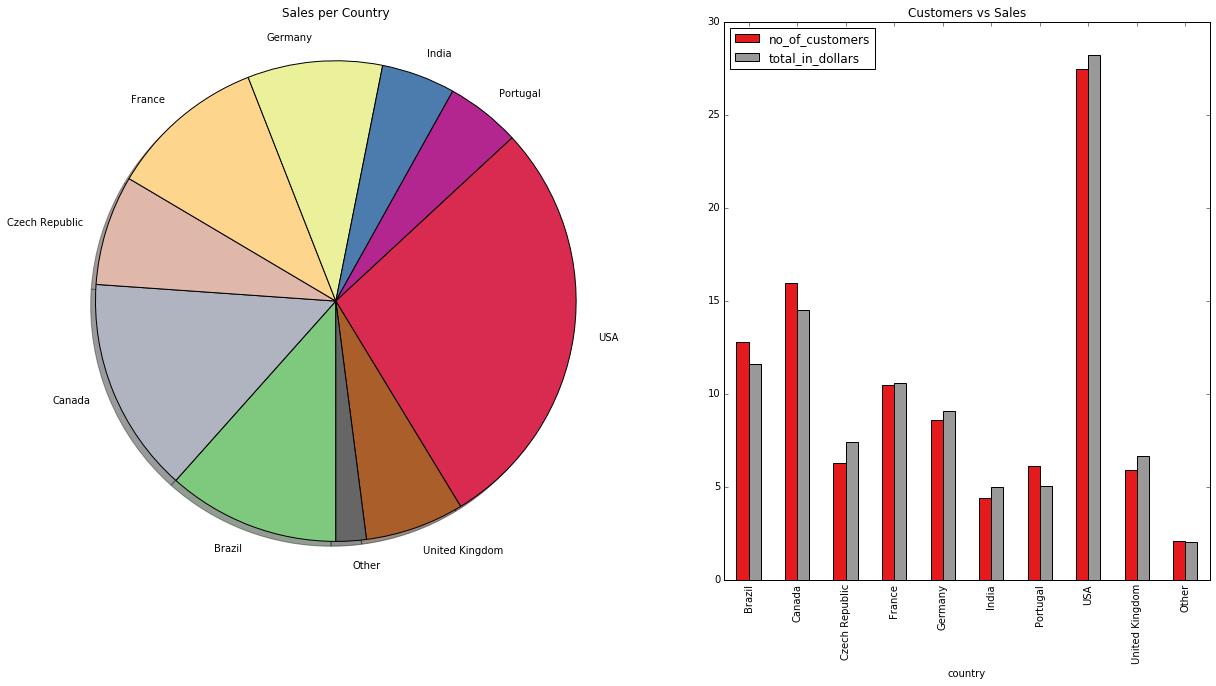

In [19]:
#countries = list(country_metrics.index)
#cust_sum = country_metrics['no_of_customers'].sum()
sales_country = list(country_metrics['total_in_dollars'].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales = country_metrics['total_in_dollars'].copy().rename('')
sales.plot.pie(
    ax=ax1,
    x =sales_country,
    shadow= True,
    startangle=-90,
    counterclock=False,
    colormap = plt.cm.Accent,
    title='Sales per Country')
ax1.axis('equal')
ax1.set_xlabel('')
ax1.set_ylabel('')

#top right
nc_ds = ['no_of_customers','total_in_dollars']
no_cust = country_metrics[nc_ds].copy()

for each in nc_ds:
    no_cust[each] /= no_cust[each].sum() / 100
    
no_cust.plot.bar(
    ax = ax2,
    colormap = plt.cm.Set1,
    title = "Customers vs Sales")
plt.show()

In [32]:
q_album='''
        SELECT
            a.album_id,
            a.title album_title,
            t.track_id,
            t.name track_name
        FROM
            album a 
        LEFT JOIN
            track t
        ON
            t.album_id = a.album_id
'''

run_query(q_album)

,album_id,album_title,track_id,track_name
0,1,For Those About To Rock We Salute You,1,For Those About To Rock (We Salute You)
1,1,For Those About To Rock We Salute You,6,Put The Finger On You
2,1,For Those About To Rock We Salute You,7,Let's Get It Up
3,1,For Those About To Rock We Salute You,8,Inject The Venom
4,1,For Those About To Rock We Salute You,9,Snowballed
5,1,For Those About To Rock We Salute You,10,Evil Walks
6,1,For Those About To Rock We Salute You,11,C.O.D.
7,1,For Those About To Rock We Salute You,12,Breaking The Rules
8,1,For Those About To Rock We Salute You,13,Night Of The Long Knives
9,1,For Those About To Rock We Salute You,14,Spellbound


In [34]:
q_album_t='''
        SELECT album_id FROM track 
        EXCEPT
        SELECT album_id FROM album
'''

run_query(q_album_t)

,album_id


In [51]:
q_invoice='''
        SELECT
            il.invoice_id,
            il.invoice_line_id,
            il.track_id,
            t.album_id
        FROM
            track t
        INNER JOIN
            invoice_line il
        ON
            il.track_id = t.track_id
'''
run_query(q_invoice)

,invoice_id,invoice_line_id,track_id,album_id
0,1,1,1158,91
1,1,2,1159,91
2,1,3,1160,91
3,1,4,1161,91
4,1,5,1162,91
5,1,6,1163,91
6,1,7,1164,91
7,1,8,1165,91
8,1,9,1166,91
9,1,10,1167,91


In [58]:
q_album_1='''
    WITH
        all_info AS
            (
             SELECT
                il.invoice_id,
                il.invoice_line_id,
                il.track_id,
                t.album_id
             FROM
                track t
            INNER JOIN
                invoice_line il
            ON
                il.track_id = t.track_id
             )
    SELECT
        invoice_id,
        Min(invoice_line_id) invoice_first_line,
        track_id invoice_first_track
    FROM all_info
    GROUP BY 1
'''

run_query(q_album_1)

,invoice_id,invoice_first_line,invoice_first_track
0,1,1,1158
1,2,17,3476
2,3,27,2516
3,4,29,3448
4,5,37,1986
5,6,54,1045
6,7,56,3477
7,8,67,2231
8,9,77,206
9,10,86,2663


In [73]:
q_album_2='''
    WITH
        all_info AS
            (
             SELECT
                il.invoice_id,
                il.invoice_line_id,
                il.track_id,
                t.album_id
             FROM
                track t
            INNER JOIN
                invoice_line il
            ON
                il.track_id = t.track_id
             ),
             
          invoice_first_track AS
              (
               SELECT
                   invoice_id,
                   album_id,
                   Min(invoice_line_id) invoice_first_line,
                   track_id first_track_id
               FROM all_info
               GROUP BY 1
              )
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                         SELECT
                            COUNT(*)
                         FROM invoice
                        ) percent
FROM
    (
    SELECT
        ift.*,
        CASE 
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                            SELECT t2.album_id from track t2
                            WHERE t2.album_id = ift.album_id
                                    )

                EXCEPT

                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = ift.invoice_id
                ) IS NULL

                AND

                (
                SELECT il.track_id FROM invoice_line il
                WHERE il.invoice_id = ift.invoice_id

                EXCEPT

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                            SELECT t2.album_id from track t2
                            WHERE t2.album_id = ift.album_id
                                    )
                ) IS NULL
            THEN "YES"
            ELSE "NO"
        END AS album_purchase
    FROM invoice_first_track ift
    )
GROUP BY 1
'''

run_query(q_album_2)

,album_purchase,number_of_invoices,percent
0,NO,500,0.814332
1,YES,114,0.185668


Album purchases are only 18.6% of the total purchases.

I would recommend against restricting to only albums. Since the most purchases are from select tracks.